## Few-Shot Transfer under Changing Causal Dynamics

In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import leap
import numpy as np
import scipy
from LiLY.datasets.sim_dataset import TimeVaryingDataset
from LiLY.modules.change import TimeVaryingProcess
from LiLY.modules.metrics.correlation import correlation
import random
import seaborn as sns
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from leap.tools.utils import load_yaml
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
data = TimeVaryingDataset(directory = '/srv/data/lily/data', 
                          transition='pnl_change_5',
                          dataset='source')
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=2560, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [8]:
cfg = load_yaml('../LiLY/configs/change_5.yaml')

In [42]:
for param in model.parameters():
    param.requires_grad = False

In [29]:
model = TimeVaryingProcess.load_from_checkpoint(checkpoint_path='/srv/data/lily/log/weiran/change_5/lightning_logs/version_3/checkpoints/epoch=49-step=153890.ckpt',
                               input_dim=cfg['VAE']['INPUT_DIM'],
                               length=cfg['VAE']['LENGTH'],
                               z_dim=cfg['VAE']['LATENT_DIM'], 
                               lag=cfg['VAE']['LAG'],
                               nclass=cfg['VAE']['NCLASS'],
                               hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                               embedding_dim=cfg['VAE']['EMBED_DIM'],
                               trans_prior=cfg['VAE']['TRANS_PRIOR'],
                               lr=cfg['VAE']['LR'],
                               infer_mode=cfg['VAE']['INFER_MODE'],
                               beta=cfg['VAE']['BETA'],
                               gamma=cfg['VAE']['GAMMA'],
                               decoder_dist=cfg['VAE']['DEC']['DIST'],
                               correlation=cfg['MCC']['CORR'])

/home/weiran/project/LiLY/LiLY/modules/components/beta.py:299: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [30]:
batch = next(iter(train_loader))
batch_size = batch['xt'].shape[0]

In [31]:
latent_size = 8

In [32]:
z, mu, logvar = model.forward(batch)
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,2,:].detach().cpu().numpy()
B = batch['yt'][:,2,:].detach().cpu().numpy()
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,latent_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

Permutation: [3 6 2 1 4 0 7 5]
Sign Flip: [-1.  1. -1.  1.  1. -1. -1. -1.]


In [33]:
figure_path = '/home/weiran/figs/'

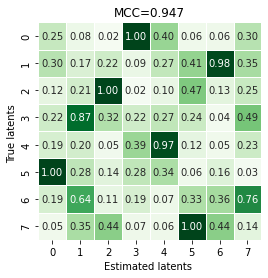

In [34]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(figure_path + '/mcc_change.pdf') as pdf:
    fig = plt.figure(figsize=(4,4))
    sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
    plt.xlabel("Estimated latents ") 
    plt.ylabel("True latents ") 
    plt.title("MCC=%.3f"%np.abs(C[row_ind, col_ind]).mean());
    pdf.savefig(fig, bbox_inches="tight")

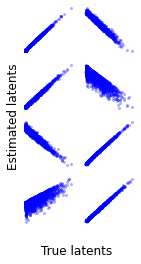

In [35]:
fig, axs = plt.subplots(4,2, figsize=(2,4))
with PdfPages(figure_path + '/scatter_change.pdf') as pdf:
    for i in range(8):
        row = i // 2
        col = i % 2
        ax = axs[row,col]
        ax.scatter(B[:,i], A[:,i], s=4, color='b', alpha=0.25)
        ax.axis('off')
    #     ax.set_xlabel('Ground truth latent')
    #     ax.set_ylabel('Estimated latent')
    #     ax.grid('..')
    # fig.tight_layout()
    fig.supxlabel('True latents')
    fig.supylabel('Estimated latents')
    pdf.savefig(fig, bbox_inches="tight")

In [74]:
class FewShotTransfer(nn.Module):
    
    def __init__(self, vae_model, embed_dims=2):
        super().__init__()
        self.model = vae_model
        for param in self.model.parameters():
            # Freeze
            param.requires_grad = False
        self.embedding = nn.Parameter(torch.zeros(1,embed_dims))
    
    def forward(self, x):
        batch_size = x['yt'].shape[0]
        embeddings = self.embedding.repeat(batch_size, 1)
        loss = self.model.transfer(x, embeddings)
        return loss

In [151]:
shots = 64

In [152]:
target_data = TimeVaryingDataset(directory = '/srv/data/lily/data', 
                                 transition='pnl_change_5',
                                 dataset='target')
num_validation_samples = 2500
train_data, val_data = random_split(target_data, [len(target_data)-num_validation_samples, num_validation_samples])
target_train_loader = DataLoader(train_data, batch_size=shots, shuffle=False, pin_memory=True)
target_val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [153]:
batch = next(iter(target_train_loader))
batch_size = batch['xt'].shape[0]

In [154]:
transfer_model = FewShotTransfer(model, 2)

In [155]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), 
                             lr=0.01)

In [156]:
for i in range(1000):
    print(loss.detach(), transfer_model.embedding.detach())
    loss = transfer_model(batch)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(0.3072) tensor([[0., 0.]])
tensor(0.7928) tensor([[ 0.0100, -0.0100]])
tensor(0.7453) tensor([[ 0.0200, -0.0199]])
tensor(0.7301) tensor([[ 0.0300, -0.0299]])
tensor(0.7379) tensor([[ 0.0400, -0.0399]])
tensor(0.6447) tensor([[ 0.0501, -0.0499]])
tensor(0.6888) tensor([[ 0.0602, -0.0600]])
tensor(0.6559) tensor([[ 0.0702, -0.0700]])
tensor(0.6108) tensor([[ 0.0800, -0.0800]])
tensor(0.5708) tensor([[ 0.0893, -0.0894]])
tensor(0.5555) tensor([[ 0.0981, -0.0985]])
tensor(0.6000) tensor([[ 0.1065, -0.1072]])
tensor(0.5496) tensor([[ 0.1148, -0.1157]])
tensor(0.5758) tensor([[ 0.1229, -0.1240]])
tensor(0.5137) tensor([[ 0.1308, -0.1321]])
tensor(0.5521) tensor([[ 0.1387, -0.1404]])
tensor(0.5050) tensor([[ 0.1465, -0.1489]])
tensor(0.5046) tensor([[ 0.1542, -0.1573]])
tensor(0.4450) tensor([[ 0.1617, -0.1657]])
tensor(0.4919) tensor([[ 0.1690, -0.1738]])
tensor(0.4656) tensor([[ 0.1761, -0.1818]])
tensor(0.5051) tensor([[ 0.1830, -0.1894]])
tensor(0.4841) tensor([[ 0.1895, -0.1966]]

tensor(0.2821) tensor([[0.6114, 0.0098]])
tensor(0.2693) tensor([[0.6115, 0.0099]])
tensor(0.2784) tensor([[0.6112, 0.0103]])
tensor(0.2759) tensor([[0.6105, 0.0107]])
tensor(0.2816) tensor([[0.6100, 0.0111]])
tensor(0.2707) tensor([[0.6094, 0.0117]])
tensor(0.2874) tensor([[0.6077, 0.0126]])
tensor(0.2769) tensor([[0.6058, 0.0136]])
tensor(0.2741) tensor([[0.6044, 0.0142]])
tensor(0.2780) tensor([[0.6032, 0.0149]])
tensor(0.2746) tensor([[0.6031, 0.0149]])
tensor(0.2828) tensor([[0.6031, 0.0149]])
tensor(0.2759) tensor([[0.6036, 0.0148]])
tensor(0.2777) tensor([[0.6040, 0.0145]])
tensor(0.2765) tensor([[0.6044, 0.0143]])
tensor(0.2737) tensor([[0.6047, 0.0142]])
tensor(0.2869) tensor([[0.6052, 0.0141]])
tensor(0.2843) tensor([[0.6055, 0.0140]])
tensor(0.2853) tensor([[0.6059, 0.0137]])
tensor(0.2714) tensor([[0.6066, 0.0135]])
tensor(0.2738) tensor([[0.6072, 0.0132]])
tensor(0.2778) tensor([[0.6076, 0.0131]])
tensor(0.2750) tensor([[0.6083, 0.0129]])
tensor(0.2929) tensor([[0.6090, 0.

tensor(0.2997) tensor([[0.6142, 0.0135]])
tensor(0.2811) tensor([[0.6135, 0.0139]])
tensor(0.2801) tensor([[0.6122, 0.0145]])
tensor(0.2686) tensor([[0.6114, 0.0149]])
tensor(0.2829) tensor([[0.6107, 0.0154]])
tensor(0.2832) tensor([[0.6108, 0.0154]])
tensor(0.2890) tensor([[0.6103, 0.0156]])
tensor(0.2827) tensor([[0.6102, 0.0157]])
tensor(0.2833) tensor([[0.6101, 0.0158]])
tensor(0.2762) tensor([[0.6097, 0.0160]])
tensor(0.2778) tensor([[0.6091, 0.0162]])
tensor(0.2887) tensor([[0.6079, 0.0167]])
tensor(0.2837) tensor([[0.6073, 0.0169]])
tensor(0.2807) tensor([[0.6076, 0.0167]])
tensor(0.2740) tensor([[0.6085, 0.0163]])
tensor(0.2873) tensor([[0.6094, 0.0156]])
tensor(0.2660) tensor([[0.6105, 0.0151]])
tensor(0.2931) tensor([[0.6117, 0.0146]])
tensor(0.2752) tensor([[0.6122, 0.0143]])
tensor(0.2715) tensor([[0.6125, 0.0139]])
tensor(0.2806) tensor([[0.6130, 0.0131]])
tensor(0.2825) tensor([[0.6136, 0.0124]])
tensor(0.2844) tensor([[0.6139, 0.0122]])
tensor(0.2717) tensor([[0.6136, 0.

KeyboardInterrupt: 

In [ ]:
[ 0.4463, -0.1148]

In [77]:
transfer_model(batch)

tensor(2.5160, grad_fn=<AddBackward0>)

In [ ]:
NL + Generalized Gaussian Noise

In [188]:
theta_dyn = np.zeros((5,2))
for d_idx in range(5):
    W2 = np.load('/srv/data/lily/data/pnl_modular_5/source/W2_%d.npy'%d_idx)
    theta_dyn[d_idx, 0] = W2[1,2]
    theta_dyn[d_idx, 1] = W2[3,4]

In [189]:
theta_hat = model.dyn_embed_func(torch.LongTensor([0,1,2,3,4])).detach().numpy()

In [190]:
from matplotlib.patches import FancyArrowPatch 

In [191]:
from matplotlib.patches import FancyArrowPatch 

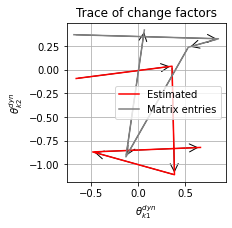

In [345]:
theta_hat = theta_hat.detach().numpy()
theta_dyn = theta_dyn.detach().numpy()

fig, ax = plt.subplots(figsize=(3,3))
ax.set_aspect("equal")
ax.plot(theta_hat[:,0], theta_hat[:,1], color='red', label='Estimated')
ax.plot(theta_dyn[:,0], theta_dyn[:,1], color='gray', label='Matrix entries')
arrow(theta_hat[:,0], theta_hat[:,1], ax, 3)
arrow(theta_dyn[:,0], theta_dyn[:,1], ax, 3)
plt.tight_layout()
plt.legend()
plt.grid()
plt.xlabel(r'$\theta_{k1}^{dyn}$')
plt.ylabel(r'$\theta_{k2}^{dyn}$')
plt.title('Trace of change factors')
def arrow(x,y,ax,n):
    d = len(x)//(n+1)    
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]), 
                              arrowstyle='->', mutation_scale=20)
        ax.add_patch(ar)

In [359]:
np.linalg.inv(theta_hat.T @ theta_hat) @ (theta_hat.T @ theta_dyn)

array([[ 0.7634366 ,  0.5584793 ],
       [-0.02744316,  0.16442966]], dtype=float32)

In [355]:
R = np.random.rand(2,2)

In [357]:
(theta_hat - theta_dyn @ R)

array([[-0.69237621, -0.19672908],
       [-0.36935343, -0.41940991],
       [-0.10224308, -1.41819704],
       [ 0.48799991, -0.15370551],
       [ 0.2149604 , -1.14880499]])

In [ ]:
5,2 

In [358]:
theta_dyn.shape

(5, 2)

In [290]:
rotation

Parameter containing:
tensor([-0.2278], requires_grad=True)

In [270]:
rotation.grad

tensor([0.])

In [255]:
rotation.data.add_(-1, rotation.grad)

/tmp/ipykernel_2979/960937127.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  rotation.data.add_(-1, rotation.grad)


TypeError: add_() takes 1 positional argument but 2 were given

/tmp/ipykernel_2979/587205299.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  rotation.grad[0]


TypeError: 'NoneType' object is not subscriptable

In [244]:
rotation.grad

/tmp/ipykernel_2979/1116664041.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  rotation.grad


In [240]:
rotation.grad[0]

tensor(2.5513)

In [225]:
rotation.grad

tensor([0.2551])

In [217]:
loss

tensor(0.4698, grad_fn=<MseLossBackward>)

In [207]:
rotation_matrix

tensor([[1., 0.],
        [-0., 1.]], grad_fn=<CopySlices>)

In [202]:
rotation

Parameter containing:
tensor([0.], requires_grad=True)

In [194]:
theta_hat.shape

(5, 2)

In [167]:
MeanMat = np.load('/srv/data/lily/data/pnl_modular_5/source/meanMat.npy')
VarMat = np.load('/srv/data/lily/data/pnl_modular_5/source/varMat.npy')

In [181]:
theta_obs = np.concatenate((MeanMat,VarMat), axis=-1)

In [182]:
theta_hat = model.obs_embed_func(torch.LongTensor([0,1,2,3,4])).detach().numpy()

Text(0, 0.5, '$\\theta_{1k}^{obs}$')

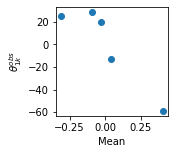

In [185]:
plt.figure(figsize=(2,2))
plt.scatter(theta_obs[:,0], theta_hat[:,0])
plt.xlabel('Mean')
plt.ylabel(r'$\theta_{1k}^{obs}$')

Text(0, 0.5, '$\\theta_{2k}^{obs}$')

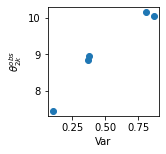

In [187]:
plt.figure(figsize=(2,2))
plt.scatter(theta_obs[:,1], theta_hat[:,1])
plt.xlabel('Var')
plt.ylabel(r'$\theta_{2k}^{obs}$')

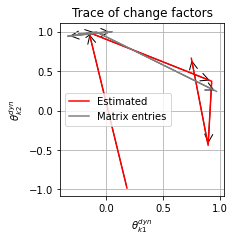

In [165]:
fig, ax = plt.subplots(figsize=(3,3))
# ax.set_aspect("equal")
plt.tight_layout()
ax.plot(theta_hat[:,0], theta_hat[:,1], color='red', label='Estimated')
ax.plot(theta_obs[:,0], theta_obs[:,1], color='gray', label='Matrix entries')
arrow(theta_hat[:,0], theta_hat[:,1], ax, 3)
arrow(theta_obs[:,0], theta_obs[:,1], ax, 3)
plt.legend()
plt.grid()
plt.xlabel(r'$\theta_{k1}^{dyn}$')
plt.ylabel(r'$\theta_{k2}^{dyn}$')
plt.title('Trace of change factors')
def arrow(x,y,ax,n):
    d = len(x)//(n+1)    
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]), 
                              arrowstyle='->', mutation_scale=20)
        ax.add_patch(ar)